# VASP CdTe benchmark performance

This notebook compares the performance of the CdTe benchmark (hybrid DFT, exact exchange) between ARCHER and ARCHER2 and for VASP compiled with different numerical libraries on ARCHER2.

We compute performance using the maximum time per SCF cycle from all cycles in the output file. The maximum is used as SCF cycles are non-homogeneous in this VASP benchmark with extra work being done in the later SCF cycles. In the full calculation from which this benchmark is extracted, the long SCF cycles make up the majority of the cycles and dominate the runtime.

Performance is plotted as SCF cycles per second (i.e. inverse of maximum SCF cycle time in seconds).

All calculations were performed with VASP 5.4.4.pl2:

- On ARCHER: Intel Compilers 17, FFTW, Intel MKL 17
- On ARCHER2: GCC 10.1.0, FFTW 3.3.8.8, HPE Cray MPICH 8.0.16 and various numerical libraries

## Setup section

Import the required modules and define useful functions.

In [8]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set(font_scale=1.5, context="paper", style="white", font="serif")
pal = sns.color_palette()
cols = pal.as_hex()

In [9]:
import sys
sys.path.append('../../../python-modules')

In [10]:
from utilities import filemanip, sysinfo
from appanalysis import vasp

In [11]:
sysdetails = sysinfo.getdetails('../../../systems.yaml')

## Process data

In [12]:
results = ['ARCHER', 'ARCHER2-4c_LibSci-20.10','ARCHER2-4c_MKL-19.5','ARCHER2-4c_MKL-21.2','ARCHER2-4c_AOCL-3.0',
           'ARCHER2_VASP544_LibSci-21.04', 'ARCHER2_VASP630_LibSci-21.04', 'ARCHER2_VASP630_AOCL-3.1']
systems = {
    'ARCHER': 'ARCHER',
    'ARCHER2-4c_LibSci-20.10': 'ARCHER2',
    'ARCHER2-4c_MKL-19.5': 'ARCHER2',
    'ARCHER2-4c_MKL-21.2': 'ARCHER2',
    'ARCHER2-4c_AOCL-3.0': 'ARCHER2',
    'ARCHER2_VASP544_LibSci-21.04': 'ARCHER2',
    'ARCHER2_VASP630_LibSci-21.04': 'ARCHER2',
    'ARCHER2_VASP630_AOCL-3.1': 'ARCHER2'}
perf = {}
notes = {}
names = {}
nodes = {}
cores = {}
perf_nodes = {}
perf_cores = {}
cpn = {}

for res in results:
    wdir = '../CdTe_Hybrid/results/' + res
    filelist = filemanip.get_filelist(wdir, 'CdTe_')
    sysdict = sysdetails[systems[res]]
    names[res] = res
    cpn[res] = sysdict['PCores']*sysdict['PPerNode']
    print('\n============================================================')
    print(res)
    vasp_df = pd.DataFrame(vasp.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode'], perftype="max"))
    nodes[res], perf_nodes[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=True, plot_cores=False)
    cores[res], perf_cores[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=False, plot_cores=True)
    print('\n============================================================')


ARCHER


/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
8     192       1       192   8     12   2     0.000080  0.000080  0.000080   
16    384       1       384   8     24   2     0.000153  0.000153  0.000153   
                              24    8    2     0.000124  0.000124  0.000124   
32    768       1       768   8     48   2     0.000269  0.000269  0.000269   
                              48    8    2     0.000118  0.000118  0.000118   
50    1200      1       1200  8     75   2     0.000400  0.000400  0.000400   
64    1536      1       1536  8     96   2     0.000424  0.000424  0.000424   

                                                                SCF  \
                                                   mean         min   
Nodes Processes Threads Cores NCORE NPAR KPAR                      

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
1     128       1       128   2     32   2     0.000033  0.000033  0.000033   
                              8     8    2     0.000033  0.000033  0.000033   
2     256       1       256   2     64   2     0.000063  0.000063  0.000063   
                              4     32   2     0.000074  0.000074  0.000074   
                              8     16   2     0.000060  0.000065  0.000066   
                              16    8    2     0.000070  0.000070  0.000070   
4     256       1       256   8     16   2     0.000096  0.000096  0.000096   
      512       1       512   2     128  2     0.000110  0.000111  0.000113   
                              4     64   2     0.000133  0.000141  0.000142   
                              8     32   2     0.000

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
1     128       1       128   4     16   2     0.000042  0.000042  0.000042   
                              8     8    2     0.000041  0.000041  0.000041   
                              16    4    2     0.000038  0.000038  0.000038   
2     256       1       256   4     32   2     0.000078  0.000079  0.000079   
                              8     16   2     0.000066  0.000066  0.000066   
                              16    8    2     0.000076  0.000076  0.000076   
                              32    4    2     0.000062  0.000062  0.000062   
4     512       1       512   4     64   2     0.000145  0.000145  0.000145   
                              8     32   2     0.000143  0.000143  0.000143   
                              16    16   2     0.000

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
1     128       1       128   2     32   2     0.000034  0.000034  0.000034   
2     256       1       256   4     32   2     0.000077  0.000077  0.000077   
4     512       1       512   4     64   2     0.000147  0.000147  0.000147   
8     1024      1       1024  4     128  2     0.000267  0.000267  0.000267   
16    2048      1       2048  16    64   2     0.000423  0.000423  0.000423   
32    4096      1       4096  16    128  2     0.000645  0.000645  0.000645   
64    8192      1       8192  16    256  2     0.000641  0.000641  0.000641   

                                                                SCF  \
                                                   mean         min   
Nodes Processes Threads Cores NCORE NPAR KPAR                      

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
1     128       1       128   2     32   2     0.000033  0.000033  0.000033   
2     256       1       256   2     64   2     0.000060  0.000060  0.000060   
                              4     32   2     0.000075  0.000075  0.000075   
4     512       1       512   4     64   2     0.000137  0.000137  0.000137   
8     1024      1       1024  4     128  2     0.000115  0.000183  0.000251   
16    2048      1       2048  16    64   2     0.000413  0.000413  0.000413   
32    4096      1       4096  16    128  2     0.000611  0.000611  0.000611   
64    8192      1       8192  16    256  2     0.000665  0.000665  0.000665   

                                                                SCF  \
                                                   mean    

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
2     256       1       256   2     64   2     0.000059  0.000059  0.000059   
                              4     32   2     0.000074  0.000074  0.000074   
4     512       1       512   2     128  2     0.000111  0.000111  0.000111   
                              4     64   2     0.000138  0.000138  0.000138   
8     1024      1       1024  2     256  2     0.000148  0.000148  0.000148   
                              4     128  2     0.000250  0.000250  0.000250   
16    2048      1       2048  8     128  2     0.000325  0.000325  0.000325   
                              16    64   2     0.000426  0.000426  0.000426   
32    4096      1       4096  8     256  2     0.000400  0.000400  0.000400   
                              16    128  2     0.000

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
1     128       1       128   4     16   2     0.000053  0.000053  0.000053   
2     256       1       256   2     64   2     0.000075  0.000075  0.000075   
                              4     32   2     0.000101  0.000101  0.000101   
4     512       1       512   2     128  2     0.000136  0.000136  0.000136   
                              4     64   2     0.000181  0.000181  0.000181   
8     1024      1       1024  2     256  2     0.000188  0.000188  0.000188   
                              4     128  2     0.000320  0.000320  0.000321   
16    2048      1       2048  8     128  2     0.000439  0.000439  0.000439   
                              16    64   2     0.000479  0.000479  0.000479   
32    2048      1       2048  16    64   2     0.000

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


## Performance Comparison

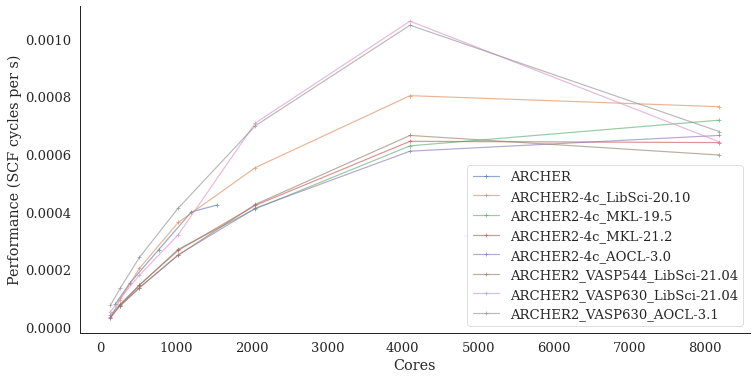

In [13]:
for res in results:
    plt.plot(cores[res], perf_cores[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Cores')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

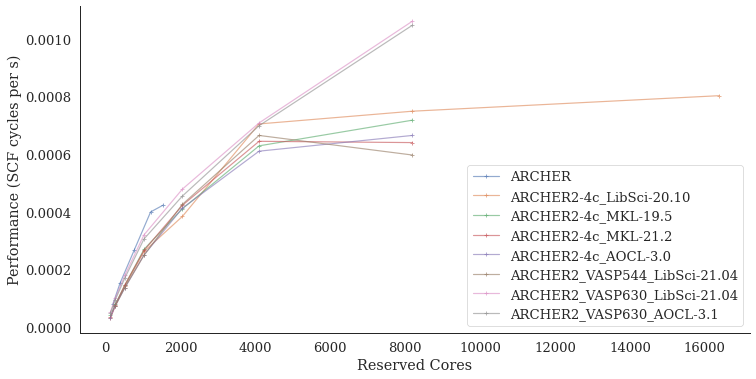

In [14]:
for res in results:
    totcores = [n * cpn[res] for n in nodes[res]]
    plt.plot(totcores, perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Reserved Cores')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()